### Initial Configurations and Imports

In [65]:
import json
import logging

import numpy as np
import seaborn as sns

from scipy.stats import wilcoxon
import matplotlib.colors as mcolors
from pathlib import Path
from tqdm import tqdm
 
from src.utils.data import *
from src.utils.plots import *
from src.utils.sampling import *
from src.utils.memory_management import *
from src.utils.statistics_utils import *

# Set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler
sh = logging.StreamHandler()
sh.setLevel(logging.INFO)
# Add the handler to the logger
logger.addHandler(sh)

from src.configs.config_parser import PathConfigParser, data_config_file, project_root

# Configs Directory
parser = PathConfigParser(str(data_config_file))
parser.load()

# Data Paths
PROCESSED_DATA_PATH = project_root / parser.get("data_paths", {}).get("processed_data")
GE_PATH = parser.get("data_paths", {}).get("brain_regions_genes_ge")
PROCESSED_DONORS_GE_PATH = PROCESSED_DATA_PATH / GE_PATH

OUTPUT_DATA = project_root / parser.get("output_paths", {}).get("stats")

# Donors_ids
DONORS_IDS = parser.get("donors_ids")

### Load Clustered Data

In [66]:
number_of_cluster = 3
cluster_data = {}
for c in range(0,number_of_cluster):
    pth = PROCESSED_DONORS_GE_PATH / Path(f"cluster_{c}.csv")
    cluster_data[c] = load_df_from_csv(pth)
    cluster_data[c]["gene_expression_values"]=cluster_data[c]["gene_expression_values"].apply(json.loads)



### Get Counts Per threshold for each cluster

In [67]:
count_per_threshold_clustered = []
range_with_powers_of_two = [2**i for i in range(3, 11)] 
for c in range(0,number_of_cluster):
    count_per_threshold_clustered.append(get_br_ge_count_above_sample_size(cluster_data[c], range = range_with_powers_of_two))

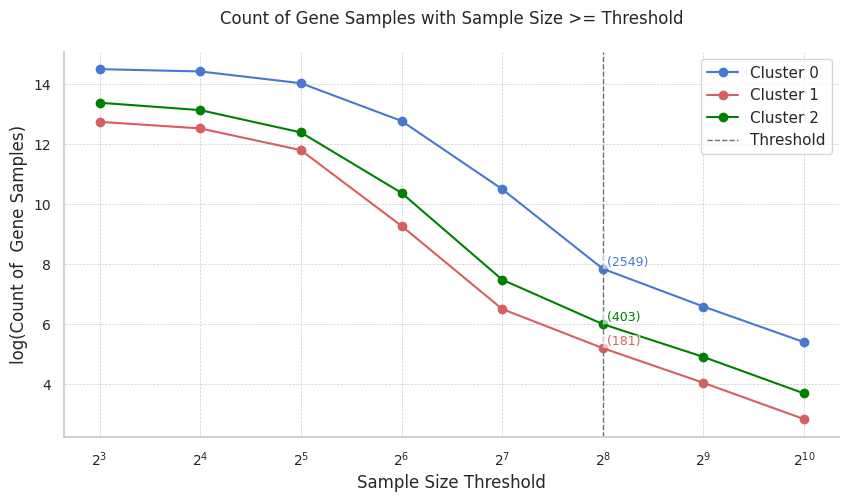

: 

In [ ]:
plot_multiple_scatter_log(range_with_powers_of_two, count_per_threshold_clustered, plot_title="Count of Gene Samples with Sample Size >= Threshold", threshold=2**8,
                    x_title="Sample Size Threshold", y_title="log(Count of  Gene Samples)", labels=['Cluster 0', 'Cluster 1', 'Cluster 2'], save=True)

In [5]:
cluster_data[0].head()

,brain_region,gene_id,gene_expression_values,sample_count,sum_expression
0,4012,2,"[1.58747780630413, 7.567907786636231, 1.495682...",22,99.030138
1,4012,3,"[5.11909080343638, 9.66921569197332, 10.081154...",44,372.348900
2,4012,6,"[1.83564765363665, 1.4949501777457102, 5.94151...",77,224.347679
3,4012,7,"[1.79544247551668, 8.01919162976325, 1.4730663...",22,106.037040
4,4012,9,"[2.20842768312641, 2.53387577054784, 3.1338710...",44,114.780258


### Filter Clusters based on the Threshold Determined from the previous plot

In [6]:
# New range
threshold = 256
range_with_powers_of_two = [2**i for i in range(3, 9)]


cluster_data_filtered = {}
# Filter based on the chosen threshold
for c in range(0,number_of_cluster):
    cluster_df_filtered = cluster_data[c].copy()

    # Get number of sample counts above threshold
    count_per_threshold= get_br_ge_count_above_sample_size(cluster_df_filtered, range = range_with_powers_of_two)

    if 'gene_expression_values' in cluster_df_filtered.columns:
        cluster_df_filtered = mask_samples_threshold(cluster_df_filtered, threshold=threshold)
    else:
        print("Error: 'gene_expression_values' column not found in DataFrame!")

    cluster_df_filtered = cluster_df_filtered.reset_index(drop=True)
    
    # Write filtered df to file.
    write_df_to_csv(cluster_df_filtered, PROCESSED_DONORS_GE_PATH / Path(f"cluster_{c}_filtered.csv"))

    logger.info(f"DF Length after filtering matches number of samples expected: {count_per_threshold[len(count_per_threshold)-1]==len(cluster_df_filtered)}")
    logger.info(count_per_threshold[len(count_per_threshold)-1])
    
    # Add filtered df in filtered data dictionary
    cluster_data_filtered[c] = cluster_df_filtered
    



DF Length after filtering matches number of samples expected: True
2549
DF Length after filtering matches number of samples expected: True
181
DF Length after filtering matches number of samples expected: True
403


In [7]:
# Step 1: Find the minimum number of rows across all dataframes
min_rows = min(len(df) for df in cluster_data_filtered.values())

# Step 2: Filter each dataframe to have the same number of rows
for key in cluster_data_filtered:
    cluster_data_filtered[key] = cluster_data_filtered[key].sample(min_rows, random_state=42)

# Step 3: Verify the result
for key, df in cluster_data_filtered.items():
    print(f"DataFrame {key} after filtering:")
    print(df)
    print()

DataFrame 0 after filtering:
      brain_region  gene_id  \
56            4023      352   
194           4023    22647   
1832          4270     2881   
233           4023    58828   
572           4048     1800   
...            ...      ...   
621           4060     2538   
168           4023     6823   
2533          9677    85727   
211           4023    34495   
727           4099     1121   

                                 gene_expression_values  sample_count  \
56    [2.12511716829593, 5.502476902190571, 4.439026...           344   
194   [4.0395251141322, 1.47672544604743, 2.08842103...           301   
1832  [7.22624794741524, 8.40354007650503, 5.2867091...           493   
233   [4.694514627381, 5.76516614330177, 5.087430468...           258   
572   [3.13739857281529, 3.42819178362219, 5.2734597...           400   
...                                                 ...           ...   
621   [4.64169394161581, 4.366197287088091, 3.243269...           735   
168   [5.22848

### Load Main `meta_donor.csv` to Calculate Stats per Gene

In [8]:
meta_donor_csv_pth = PROCESSED_DONORS_GE_PATH / Path("meta_donor.csv")
meta_donor_df = load_df_from_csv(meta_donor_csv_pth)
meta_donor_df.head(3)

meta_donor_df["gene_expression_values"]=meta_donor_df["gene_expression_values"].apply(json.loads)
logger.info(meta_donor_df["gene_expression_values"][0][0])

1.58747780630413


Calculating the population mean gene expression value per gene ID (H0) 

In [9]:
geneid_H0 = calculate_gene_mean_expression_values(meta_donor_df)
logger.info(f"Number of Total Sample Count == {geneid_H0['total_sample_count'].sum() == get_total_number_of_samples(meta_donor_df)}")

Number of Total Sample Count == True


Calculating the population std gene expression value per gene ID (H0) 

In [10]:
df_std = meta_donor_df.copy()

std_per_gene = calculate_std_gene_id_optimized(df_std)

geneid_H0["std"] = std_per_gene["std"]
write_df_to_csv(geneid_H0, OUTPUT_DATA / Path("stats/gene_stats.csv"))
geneid_H0.head(3)

,gene_id,total_expression,total_sample_count,weighted_mean,std
0,2,16227.834876,3936,4.122926,2.693218
1,3,66283.660534,7872,8.420180,2.464688
2,6,41203.873837,13776,2.990990,2.067025


### Calculating P-values, Effect Size, T-statistic and Power for Different Sample Sizes for each cluster

Data was filtered so that the minimum (181) gene samples are only drawn from each cluster

In [11]:
stats_df_clustered = {}
for c in range(0, number_of_cluster):
    stats_df = pd.DataFrame(cluster_data_filtered[c]).drop(columns=["gene_expression_values"])
    for index, br_ge in tqdm(cluster_data_filtered[c].iterrows(), total=len(cluster_data_filtered[c]), desc=f"Processing Samples from cluster {c}"):
        effect_sizes, p_values, powers, t_obs_stats =[], [], [], []
        for sample_size in range_with_powers_of_two:
            # Getting Sample Values
            sample = br_ge["gene_expression_values"]
            
            if sample_size > len(sample):
                logger.error(f"Reproducing Error, sample size available: {len(sample)} < sample_size chosen: {sample_size}")
                raise Exception
            else:
                sample = sample[:sample_size]
            
            if len(sample) == 1:
                raise ValueError
            
            # Getting Brain region and Gene ID
            gene_id = br_ge["gene_id"]
            brain_region = br_ge["brain_region"]
            
            # Calculating Sample Stats
            sample_mean = np.mean(sample)
            sample_std = np.std(sample)
            
            
            # Getting Control Group stats for that gene
            control_group_mean = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "weighted_mean"].iloc[0]
            control_group_std = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "std"].iloc[0]
            control_group_size = geneid_H0.loc[geneid_H0["gene_id"] == int(gene_id), "total_sample_count"].iloc[0]


            # (1) Calculating Effect Size.
            effect_size = calculate_cohen_d(sample_mean=sample_mean, control_group_mean=control_group_mean,
                            sample_std=sample_std, control_group_std=control_group_std,
                            sample_length=sample_size, control_group_length=control_group_size)

            # (2) Calculating Power
            power = calculate_test_power(effect_size, sample_mean, control_group_mean, sample_std, sample_size)
            
            # (3) Wilcoxon to Calculate the p_value and the t-statistic 
            t_static, p_value  = wilcoxon(np.array(sample) - control_group_mean, alternative='greater')

            stats_df.loc[index, f"effect_size_{sample_size}"] = effect_size
            stats_df.loc[index, f"p-value_{sample_size}"] = p_value
            stats_df.loc[index, f"power_{sample_size}"] = power
            stats_df.loc[index, f"t_stat_{sample_size}"] = t_static

        
    stats_df_clustered[c] = stats_df
    write_df_to_csv(stats_df, OUTPUT_DATA / Path(f"df_stats_cluster_{c}.csv"))



Processing Samples from cluster 0:   0%|          | 0/181 [00:00<?, ?it/s]

Processing Samples from cluster 2: 100%|██████████| 181/181 [00:01<00:00, 93.47it/s]


In [12]:
stats_df_clustered[2].head(3)

,brain_region,gene_id,sample_count,sum_expression,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,...,power_64,t_stat_64,effect_size_128,p-value_128,power_128,t_stat_128,effect_size_256,p-value_256,power_256,t_stat_256
70,4254,6496,264,619.000754,0.496430,0.019531,0.353364,33.0,0.205684,0.589554,...,0.202619,622.0,0.121672,0.996903,0.391418,2977.0,0.024310,1.0,0.104391,9923.0
281,4722,3338,473,744.060152,-22.664251,1.000000,0.000000,0.0,-20.117320,1.000000,...,0.000000,68.0,-1.684775,1.000000,0.000000,395.0,-1.735685,1.0,0.000000,1549.0
283,4722,4855,308,919.485088,-3.845398,1.000000,0.000000,0.0,-2.394797,1.000000,...,0.000000,143.0,-1.258062,1.000000,0.000000,572.0,-1.225147,1.0,0.000000,2476.0


### Calculating Mean and the STD for the Effect Sizes of the most represented brain region in each cluster 

In [13]:
filtered_df_means = []
filtered_df_vars = []
filtered_dfs = {}
for c in range(0,number_of_cluster):
    # Group by brain_region and count occurrences
    group_counts = stats_df_clustered[c]["brain_region"].value_counts()
    
    # Filter out brain regions that have the most occurrences
    # valid_regions = group_counts[group_counts >= 8].index
    valid_regions = [group_counts.idxmax()]  # Get the brain region with the highest count


    # Filter original DataFrame
    filtered_df = stats_df_clustered[c][stats_df_clustered[c]["brain_region"].isin(valid_regions)].drop(columns=['gene_id'])
    filtered_dfs[c]= filtered_df
    # filtered_df = filtered_df[filtered_df['brain_region'] != 4288]
    filtered_df = filtered_df.groupby("brain_region")
    

    # Calculating Mean and Variances
    filtered_df_means.append(filtered_df.mean())
    filtered_df_vars.append(filtered_df.var())
    
# Combine all means into a single DataFrame
means_df = pd.concat(filtered_df_means)

# Combine all variances into a single DataFrame
vars_df = pd.concat(filtered_df_vars)

# Reset index to make brain_region a column instead of an index (optional)
means_df = means_df #.reset_index()
vars_df = vars_df # .reset_index()

In [14]:
ontology = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('Ontology.csv'))

4023
4417
4251


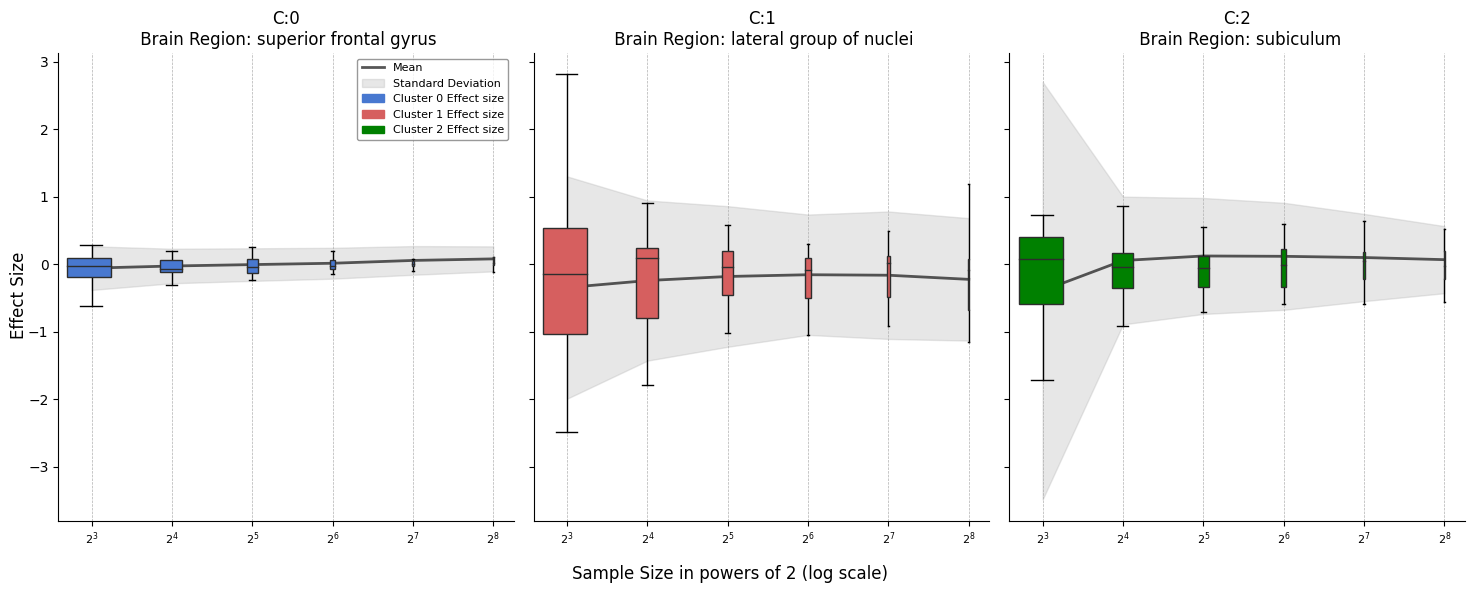

In [15]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Define columns for effect sizes
columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
effect_size_df_mean = means_df[columns]
effect_size_df_var = vars_df[columns]

# Transpose for plotting
transpose_effect_size_mean = effect_size_df_mean.T.reset_index(drop=True)
transpose_effect_size_var = effect_size_df_var.T.reset_index(drop=True)


# Initialize figure with subplots
num_regions = len(transpose_effect_size_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 6), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_effect_size_mean)):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot std as shaded region
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[column].values - np.sqrt(transpose_effect_size_var[column].values), 
                    transpose_effect_size_mean[column].values + np.sqrt(transpose_effect_size_var[column].values), 
                    color=variance_color, alpha=0.3, label="Standard Deviation")
        
    # Plot individual effect size values
    region_samples = filtered_dfs[idx]
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        
        # ax.scatter([sample_size] * len(sample_values), sample_values, 
        #         color=cluster_colors[idx], alpha=0.9, s=6, edgecolor='none')
        
        ax.boxplot(sample_values, positions=[sample_size], widths=3.0, patch_artist=True,
                boxprops=dict(facecolor=cluster_colors[idx], color=mean_color),
                medianprops=dict(color=mean_color),
                flierprops=dict(marker='o', color=cluster_colors[idx], markersize=4, alpha=0.8), showfliers=False)  # Customize outliers

        
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)  # Set logarithmic scale with base 2
    
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    
    ax.set_xlim(6, max(range_with_powers_of_two) + 50)
    print(column)
    br_name = ontology.loc[ontology['id'] == column, 'name'].str.split(",", n=1).str[0].tolist()[0]
    ax.set_title(f"C:{idx}\n Brain Region: {br_name}")
    
    # Add grid
    ax.grid(axis='y', visible=False, linestyle="--", linewidth=0.5)  # Disables only horizontal grid lines

    ax.yaxis.grid(False)  # Disables horizontal grid
    ax.xaxis.grid(True,  linestyle="--", linewidth=0.5)   # Ensures vertical grid remains

    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Filter out duplicate labels
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        
        # Add custom legend entries
        for label, color in [("Cluster 0 Effect size", cluster_colors[0]), ("Cluster 1 Effect size", cluster_colors[1]), ("Cluster 2 Effect size", cluster_colors[2]) ]:
            patch = Patch(color=color, label=label)  # Create a colored patch for the legend
            unique_handles.append(patch)
            unique_labels.append(label)
        
        # Add legend with all handles and labels
        ax.legend(unique_handles, unique_labels, loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')
        

# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size in powers of 2 (log scale)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("Effect Size", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("effect_size_vs_sample_size_clustered.png")
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

### Calculating Means and STDs for The 3 equally and most represented brain regions in each cluster

In [59]:
filtered_df_means = []
filtered_df_vars = []
filtered_dfs = {}

# Step 1: Calculate the size of each brain region in each cluster
brain_region_counts = {}
for c in range(number_of_cluster):
    group_counts = stats_df_clustered[c]["brain_region"].value_counts()
    brain_region_counts[c] = group_counts

# Step 2: Find the brain region with the highest count in the LAST cluster
last_cluster = number_of_cluster - 1
selected_region_last_cluster = brain_region_counts[last_cluster].idxmax()
target_count = brain_region_counts[last_cluster][selected_region_last_cluster]

# Step 3: For the other clusters, pick the brain region with the closest count to the target_count
selected_regions = []
for c in range(number_of_cluster):
    if c == last_cluster:
        # For the last cluster, use the brain region with the highest count
        selected_regions.append(selected_region_last_cluster)
    else:
        # For other clusters, find the brain region with the closest count to the target_count
        closest_region = brain_region_counts[c].index[np.argmax(np.abs(brain_region_counts[c] + target_count))]
        selected_regions.append(closest_region)

# Step 4: Print the selected brain regions and their counts
print("Selected brain regions and their counts:")
for c in range(number_of_cluster):
    region = selected_regions[c]
    count = brain_region_counts[c][region]
    print(f"Cluster {c}: Brain Region = {region}, Count = {count}")

# Step 5: Filter the dataframes based on the selected brain regions
for c in range(number_of_cluster):
    valid_regions = [selected_regions[c]]
    filtered_df = stats_df_clustered[c][stats_df_clustered[c]["brain_region"].isin(valid_regions)].drop(columns=['gene_id'])
    filtered_dfs[c] = filtered_df
    filtered_df = filtered_df.groupby("brain_region")

    # Calculating Mean and Variances
    filtered_df_means.append(filtered_df.mean())
    filtered_df_vars.append(filtered_df.var())

# Combine all means into a single DataFrame
means_df = pd.concat(filtered_df_means)

# Combine all variances into a single DataFrame
vars_df = pd.concat(filtered_df_vars)

# Reset index to make brain_region a column instead of an index (optional)
means_df = means_df
vars_df = vars_df

Selected brain regions and their counts:
Cluster 0: Brain Region = 4023, Count = 23
Cluster 1: Brain Region = 4417, Count = 24
Cluster 2: Brain Region = 4251, Count = 21


### Plotting Effect Size VS Sample Size for Different Clusters

In [17]:
ontology = load_df_from_csv(PROCESSED_DONORS_GE_PATH / Path('Ontology.csv'))

ontology.head(3)

if "4251" in ontology["id"].astype(str).values:
    print("4251 is present in the 'id' column.")
else:
    print("4251 is NOT present in the 'id' column.")

4251 is present in the 'id' column.


4023
4417
4251


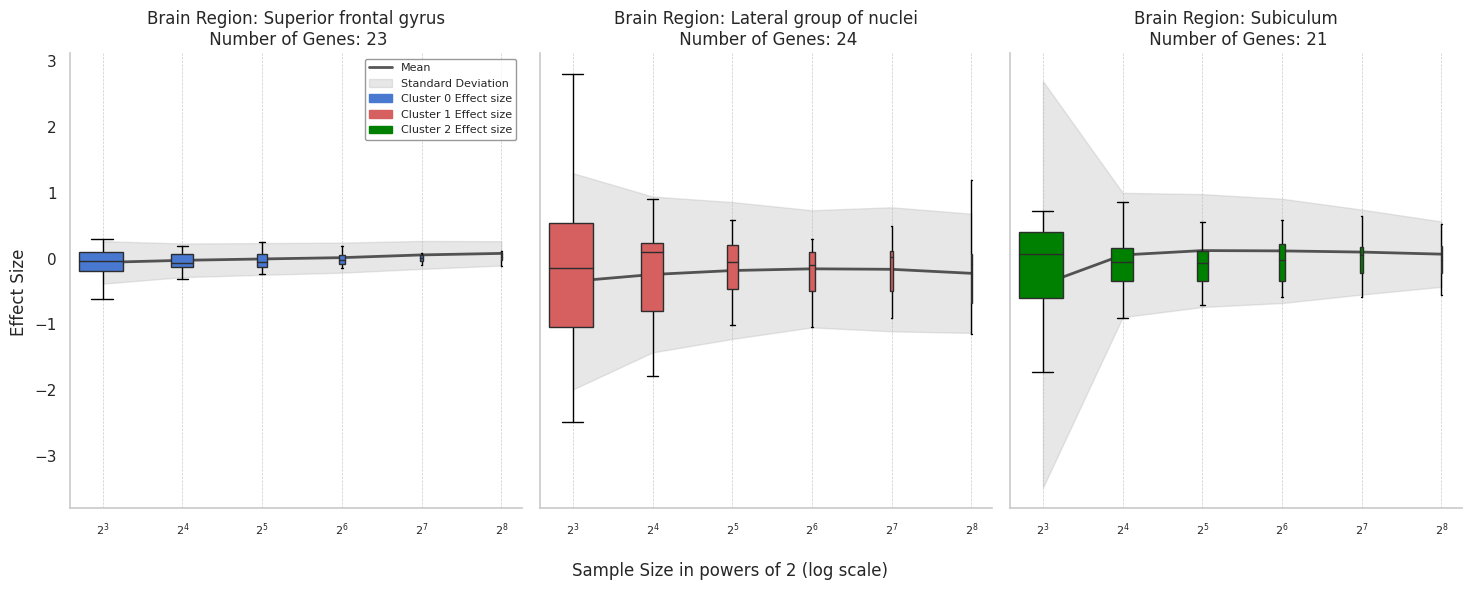

In [61]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# Define columns for effect sizes
columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two]

# Extract means and variances
effect_size_df_mean = means_df[columns]
effect_size_df_var = vars_df[columns]


# Transpose for plotting
transpose_effect_size_mean = effect_size_df_mean.T.reset_index(drop=True)
transpose_effect_size_var = effect_size_df_var.T.reset_index(drop=True)

# Initialize figure with subplots
num_regions = len(transpose_effect_size_mean.columns)
fig, axes = plt.subplots(nrows=1, ncols=num_regions, figsize=(15, 6), sharey=True)

# Plot each region in a separate subplot
for idx, (ax, column) in enumerate(zip(axes, transpose_effect_size_mean)):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot mean as solid line
    ax.plot(range_with_powers_of_two, transpose_effect_size_mean[column].values, 
            color=mean_color, linewidth=2, alpha=0.8, label="Mean")
    
    # Plot variance as shaded region"
    ax.fill_between(range_with_powers_of_two, 
                    transpose_effect_size_mean[column].values - np.sqrt(transpose_effect_size_var[column].values), 
                    transpose_effect_size_mean[column].values + np.sqrt(transpose_effect_size_var[column].values), 
                    color=variance_color, alpha=0.3, label="Standard Deviation")
    
    
    # Plot individual effect size values
    region_samples = filtered_dfs[idx]
    for sample_idx, sample_size in enumerate(range_with_powers_of_two):
        sample_values = region_samples[f"effect_size_{sample_size}"]
        
        
        sample_powers = region_samples[f"power_{sample_size}"].values
        
        # ax.scatter([sample_size] * len(sample_powers), sample_powers, 
        #         color=cluster_colors[idx], alpha=0.9, s=20, edgecolor='none')
        
        ax.boxplot(sample_values, positions=[sample_size], widths=3.0, patch_artist=True,
                boxprops=dict(facecolor=cluster_colors[idx], color=mean_color),
                medianprops=dict(color=mean_color),
                flierprops=dict(marker='o', color=cluster_colors[idx], markersize=4, alpha=0.8), showfliers=False)  # Customize outliers

        
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log")        
    # Set x-axis ticks to powers of 2
    ax.set_xticks(range_with_powers_of_two)
    ax.set_xticklabels([f"$2^{{{int(np.log2(size))}}}$" for size in range_with_powers_of_two], fontsize=8)
    
    print(column)    
    ax.set_xlim(6, max(range_with_powers_of_two) + 50)

    br_name = ontology.loc[ontology['id'] == column, 'name'].str.split(",", n=1).str[0].tolist()[0]
    ax.set_title(f"Brain Region: {br_name.capitalize()}\n Number of Genes: {brain_region_counts[idx][column]}")
    
    # Add grid
    ax.grid(axis='y', visible=False, linestyle="--", linewidth=0.5)  # Disables only horizontal grid lines
            
    # Use a logarithmic x-axis for better scaling
    ax.set_xscale("log", base=2)
    ax.yaxis.grid(False)  # Disables horizontal grid
    ax.xaxis.grid(True,  linestyle="--", linewidth=0.5)   # Ensures vertical grid remains

    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    
    # Add legend (only for the first subplot to avoid repetition)
    if idx == 0:
        # Get existing handles and labels
        handles, labels = ax.get_legend_handles_labels()
        
        # Filter out duplicate labels
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        
        # Add custom legend entries
        for label, color in [("Cluster 0 Effect size", cluster_colors[0]), ("Cluster 1 Effect size", cluster_colors[1]), ("Cluster 2 Effect size", cluster_colors[2]) ]:
            patch = Patch(color=color, label=label)  # Create a colored patch for the legend
            unique_handles.append(patch)
            unique_labels.append(label)
   
        # Add legend with all handles and labels
        ax.legend(unique_handles, unique_labels, loc="upper right", fontsize=8, frameon=True, facecolor='white', edgecolor='gray')
        

# Add a single centered x-axis label below all subplots
fig.supxlabel("Sample Size in powers of 2 (log scale)", fontsize=12, y=0.02)

# Add a single y-axis label
fig.supylabel("Effect Size", fontsize=12, x=0.02)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a file
output_filename = PLOTS_PTH / Path("effect_size_vs_sample_size_clustered.png")
plt.savefig(output_filename, dpi=300, bbox_inches='tight')

# Show plot
plt.show()

In [19]:
stats_df_clustered[0].head()

,brain_region,gene_id,sample_count,sum_expression,effect_size_8,p-value_8,power_8,t_stat_8,effect_size_16,p-value_16,...,power_64,t_stat_64,effect_size_128,p-value_128,power_128,t_stat_128,effect_size_256,p-value_256,power_256,t_stat_256
56,4023,352,344,1971.862070,0.125754,0.679688,0.093054,15.0,0.095425,0.752289,...,0.173269,847.0,0.083006,0.944991,0.238619,3456.0,0.093498,0.975085,0.439253,14122.0
194,4023,22647,301,1357.073471,0.041248,0.527344,0.061912,18.0,-0.020677,0.609024,...,0.090149,1032.0,0.006662,0.722334,0.058222,3880.0,0.000331,0.912578,0.050547,14839.0
1832,4270,2881,493,3360.080338,-0.322099,0.769531,0.006655,13.0,-0.020510,0.489975,...,0.147145,1136.0,-0.039412,0.593988,0.018381,4028.0,0.104613,0.035836,0.509781,18584.0
233,4023,58828,258,1151.485178,0.055354,0.273438,0.066457,23.0,-0.084878,0.430130,...,0.014996,1029.0,-0.040857,0.625914,0.017661,3993.0,-0.065192,0.798329,0.003625,15457.0
572,4048,1800,400,1436.627448,1.074121,0.027344,0.860535,32.0,0.577957,0.025330,...,0.939208,1462.0,0.216598,0.015046,0.785991,5040.0,0.236453,0.000304,0.983345,20513.0


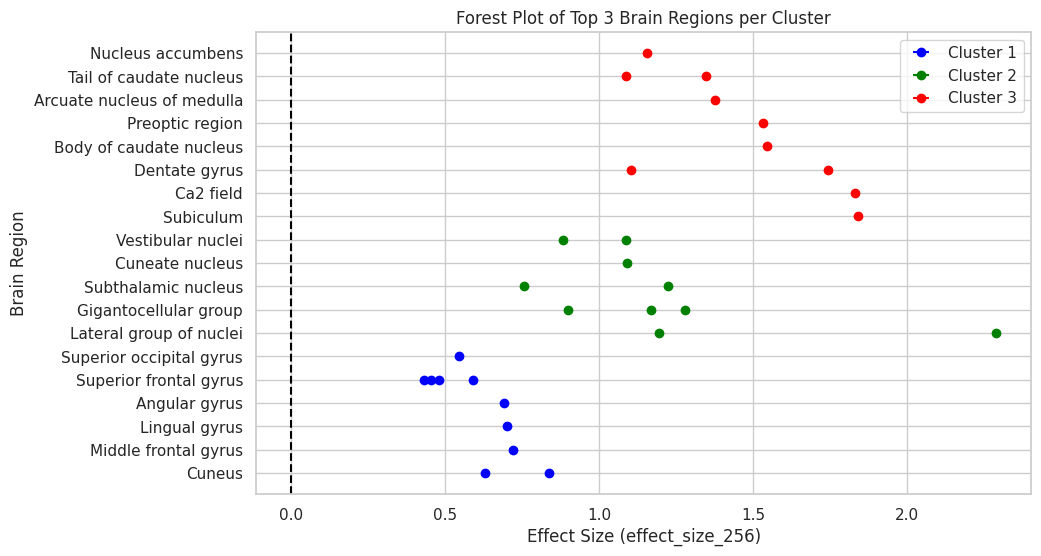

In [23]:

# Function to get brain region name
def get_brain_region_name(region_id):
    name = ontology.loc[ontology['id'] == region_id, 'name'].str.split(",", n=1).str[0].tolist()
    return name[0].capitalize() if name else "Unknown"


# Combine all clusters into a list for easier processing
clusters = [stats_df_clustered[0], stats_df_clustered[1], stats_df_clustered[2]]
cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['blue', 'green', 'red']

# Prepare the data for plotting
plot_data = []

for i, df in enumerate(clusters):
    # Sort by effect size and select top 3 regions
    top_regions = df.sort_values(by='effect_size_256', ascending=False).head(10)
    
    # Get brain region names
    top_regions['region_name'] = top_regions['brain_region'].apply(get_brain_region_name)
    
    # Add cluster information
    top_regions['cluster'] = cluster_names[i]
    
    # Append to plot data
    plot_data.append(top_regions)

# Combine all data into a single dataframe
plot_df = pd.concat(plot_data)

# Plotting
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Create the forest plot
for i, (cluster, color) in enumerate(zip(cluster_names, colors)):
    cluster_data = plot_df[plot_df['cluster'] == cluster]
    
    # Convert to numpy arrays to avoid pandas multi-dimensional indexing issues
    effect_sizes = cluster_data['effect_size_256'].to_numpy()
    region_names = cluster_data['region_name'].to_numpy()
    
    plt.errorbar(effect_sizes, region_names, 
                 xerr=0, fmt='o', color=color, label=cluster)

plt.axvline(x=0, color='black', linestyle='--')  # Add a vertical line at 0
plt.xlabel('Effect Size (effect_size_256)')
plt.ylabel('Brain Region')
plt.title('Forest Plot of Top 3 Brain Regions per Cluster')
plt.legend()
plt.show()

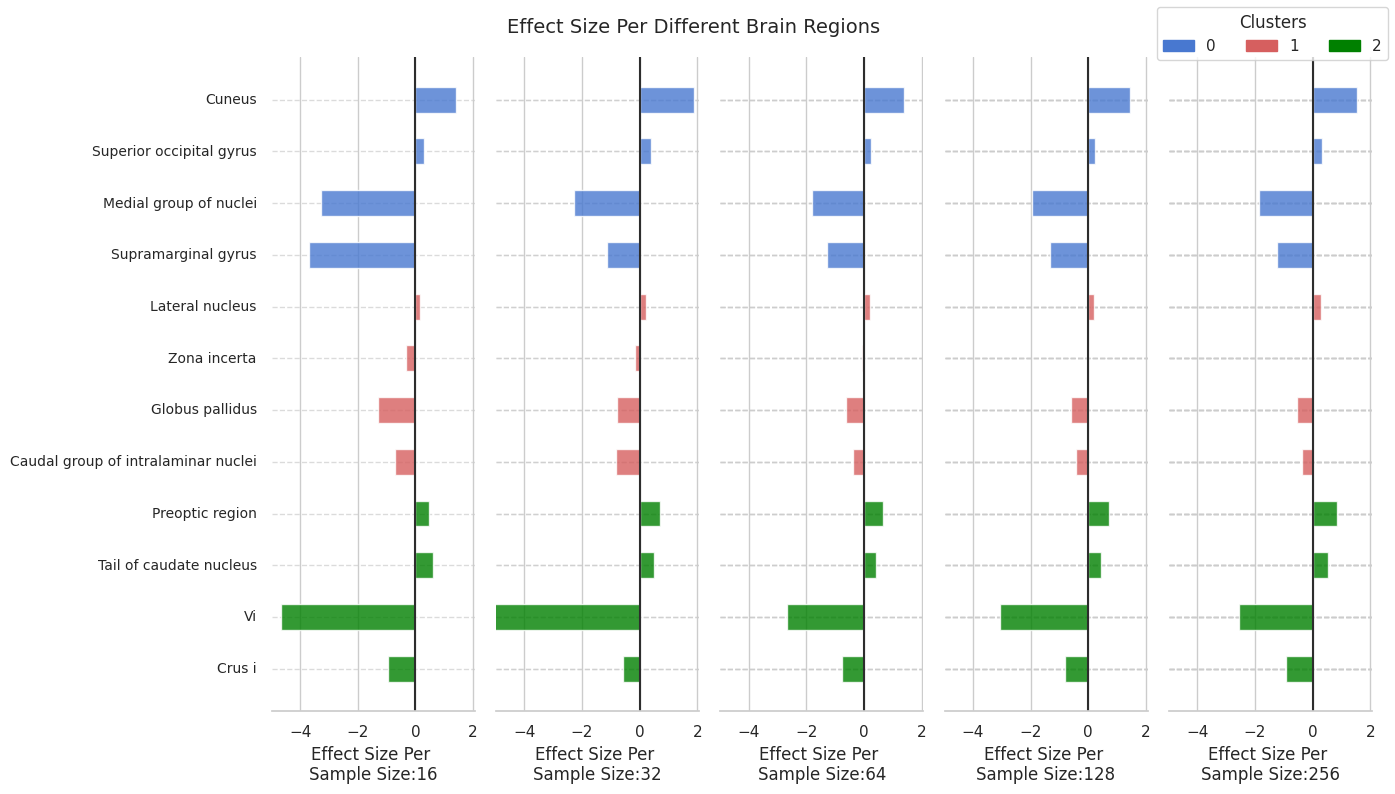

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
# Function to get brain region name
def get_brain_region_name(region_id):
    name = ontology.loc[ontology['id'] == region_id, 'name'].str.split(",", n=1).str[0].tolist()
    return name[0].capitalize() if name else "Unknown"

stats_df_clustered_means = {}

stats_df_clustered_means[0] = stats_df_clustered[0].groupby('brain_region', as_index=False).mean(numeric_only=True)
stats_df_clustered_means[1] = stats_df_clustered[1].groupby('brain_region', as_index=False).mean(numeric_only=True)
stats_df_clustered_means[2] = stats_df_clustered[2].groupby('brain_region', as_index=False).mean(numeric_only=True)


# Combine all clusters into a list for easier processing
clusters = [stats_df_clustered_means[0], stats_df_clustered_means[1], stats_df_clustered_means[2]]
cluster_names = ['Cluster 0', 'Cluster 1', 'Cluster 2']

# Prepare the data for plotting
plot_data = []

for i, df in enumerate(clusters):
    # Sort by effect size and select top 10 regions
    
    top_regions_desc = df.sort_values(by='effect_size_256', ascending=False).head(2)
    top_regions = df.sort_values(by='effect_size_256', ascending=True).head(2)
    
    # Get brain region names
    top_regions_desc['region_name'] = top_regions_desc['brain_region'].apply(get_brain_region_name)
    top_regions['region_name'] = top_regions['brain_region'].apply(get_brain_region_name)

    
    # Add cluster information
    top_regions_desc['cluster'] = cluster_names[i]
    top_regions['cluster'] = cluster_names[i]
    
    # Append to plot data
    plot_data.append(top_regions_desc)
    plot_data.append(top_regions)

# Combine all data into a single dataframe
plot_df = pd.concat(plot_data)

# Define the effect size columns to plot
effect_size_columns = [f"effect_size_{sample_size}" for sample_size in range_with_powers_of_two[1:]]

# Number of effect size columns
num_effect_sizes = len(effect_size_columns)

# Set up subplots (left for names + effect size plots)
fig, axes = plt.subplots(1, num_effect_sizes, figsize=(14, 8), gridspec_kw={'width_ratios': [0.8] * num_effect_sizes})
sns.set(style="whitegrid")

# Store all region names for alignment
all_region_names = []
for cluster in cluster_names:
    cluster_data = plot_df[plot_df['cluster'] == cluster]
    all_region_names.extend(cluster_data['region_name'].tolist())

# Reverse order for proper alignment (so top-ranked appears at the top)
all_region_names = all_region_names[::-1]

y_pos = 0
y_ticks = []  # Store y-tick positions
y_labels = []  # Store corresponding labels for verification
x_min = min(plot_df[effect_size_columns].min()) * 0.9  # Slight padding
x_max = max(plot_df[effect_size_columns].max()) * 1.1  # Slight padding
# Effect size plots
for k, effect_size_col in enumerate(effect_size_columns):
    ax = axes[k]
    
    if k == 0:
        for i, region in enumerate(all_region_names):
            ax.text(ax.get_xlim()[0] - 5.5, i, region, ha='right', va='center', fontsize=10)

    y_pos = 0
    for i, cluster in enumerate(cluster_names):
        cluster_data = plot_df[plot_df['cluster'] == cluster]
        region_names = cluster_data['region_name'].tolist()
        effect_sizes = cluster_data[effect_size_col].to_numpy()
        
        # Reverse order to match the leftmost text alignment
        region_names.reverse()
        effect_sizes = effect_sizes[::-1]
        
        # Get bar positions
        bar_positions = list(range(y_pos, y_pos + len(region_names)))
        y_ticks.extend(bar_positions)
        y_labels.extend(region_names)
        
        # Plot bars
        ax.barh(range(y_pos, y_pos + len(region_names)), effect_sizes, height=0.5, color=cluster_colors[len(cluster_colors.keys())-i-1], alpha=0.8)
        
        # Increment y-position
        y_pos += len(region_names)
    
    # Formatting
    # ax.set_xlim(-1, 5)  # Ensure all subplots have the same x-axis range
    ax.set_xlim(x_min, x_max)
    ax.set_yticks(y_ticks)  # Keep ticks but...
    ax.set_yticklabels([])  # Remove tick labels (numbers)    ax.set_xlabel(f'Effect Size {2**(k+3)}')
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    ax.set_yticks(y_ticks)  # Set y-ticks at bar positions
    ax.set_xlabel(f'Effect Size Per \nSample Size:{2**(k+4)}')
    ax.axvline(0, color=mean_color, linewidth=1.5, label="Minimum BIC Score")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

# Set a centered title across all subplots
fig.suptitle("Effect Size Per Different Brain Regions", fontsize=14)

# Create legend patches for clusters
handles = [mpatches.Patch(color=color, label=cluster) for cluster, color in zip(cluster_colors.keys(), cluster_colors.values())]

# Add a horizontal legend at the bottom
fig.legend(handles=handles, loc='upper right', ncol=len(cluster_colors), title="Clusters")

# Adjust layout
plt.tight_layout()

plt.savefig(PLOTS_PTH / Path("Brain Regions Effect Sizes Forest Plot.png"))

plt.show()
